In [17]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd

## Data Preprocessing 

In [19]:
# Importing the four files
df1 = pd.read_parquet('meterological_data_1.parquet')
df2 = pd.read_parquet('meterological_data_2.parquet')
df3 = pd.read_parquet('meterological_data_3.parquet')
df4 = pd.read_parquet('meterological_data_4.parquet')


In [24]:
df1["Change in Emphasis"][0]

{'MeterologicalData': array(['showers', 'rain', 'heavy rain', 'windy', 'coastal gales'],
       dtype=object),
 'MeterologicalDescription': array(['Early showers becoming confined to parts of Scotland',
        'Further rain, heavy at times, into the far SW during the morning then spreading N and E to many other parts later',
        'Some heavy rain', 'Windy in the S',
        'Coastal gales and risk sev coastal gales S Wales/SW England'],
       dtype=object)}

In [21]:
df1["month"] = 1
df2["month"] = 2
df3["month"] = 3
df4["month"] = 4

In [22]:
df_all = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [23]:
df_all.shape

(465, 12)

In [28]:
df5 = df_all.copy()

In [29]:
def extract_meteorological_data(cell):
    if isinstance(cell, dict) and 'MeterologicalData' in cell:
        return list(cell['MeterologicalData'])
    return cell 

# Apply to each relevant column
for col in df5.columns:
    df5[col] = df5[col].apply(extract_meteorological_data)

In [31]:
df6 = df5.copy()

In [37]:
df6["Low Cloud / Visibility"].value_counts()

Low Cloud / Visibility
[]                                                                                                                                                  146
[low cloud, showers]                                                                                                                                  6
[radiation mist/fog patches, very low ST/patchy fog, low cloud, frontal cloud]                                                                        4
[low ST, showers]                                                                                                                                     4
[cloud base, hill fog, airmass visibility]                                                                                                            3
                                                                                                                                                   ... 
[cloud fit, low cloud, cold front, fog patches, cloud bases, baro

In [38]:
df6.drop(columns=['start_date', 'end_date', 'Other / Miscellaneous'], inplace=True)

In [39]:
df6.columns

Index(['Key Points and Weather Watch', 'Change in Emphasis', 'Modifications',
       'Evolution and Discussion', 'Precipitation', 'Wind', 'Temperature',
       'Low Cloud / Visibility', 'month'],
      dtype='object')

In [41]:
df = df6.copy()

In [42]:
df.head()

Key Points and Weather Watch  \
0         [wet weather, windy]   
1         [wet weather, windy]   
2         [wet weather, windy]   
3         [wet weather, windy]   
4         [wet weather, windy]   

                                  Change in Emphasis  \
0  [showers, rain, heavy rain, windy, coastal gales]   
1  [showers, rain, windier, snow, frost, cloud, h...   
2  [showers, rain, snow, windy, frost, cloud, hea...   
3  [rain, heavy rain, snow, showers, heavy shower...   
4  [cloud, rain, heavy rain, showers, gales, seve...   

                                       Modifications  \
0                        [E’ward progression of low]   
1                                  [wave, deepening]   
2                                        [deepening]   
3  [synoptic evolution, convective airmass, wave ...   
4                                                 []   

                            Evolution and Discussion  \
0  [transient ridge, frontal zone, cold front, je...   
1  [transient ridge, frontal zone, cold front, je...   
2  [transient ridge, heavy rain, windy, mild cond...   
3                         [frontal zone, heavy rain]   
4  [occluding frontal zone, rainfall, winds, slee...   

                                       Precipitation  \
0  [frontal zone, showers, rain, MTN snow, fog pa...   
1  [frontal zone, showers, rain, MTN snow, fog pa...   
2  [frontal zone, showers, patchy rain, heavier r...   
3  [heavy rain, moderate rain, snow, frontal ppn,...   
4  [heavy rain, Snow, sleet, showers, CB, TSGR, L...   

                                                Wind           Temperature  \
0           [gales, coastal gales, sev gales, gusts]       [maxima, frost]   
1  [gales, coastal gales, sev gales, gusts, high ...       [maxima, frost]   
2              [windier, gales, severe gales, gusts]  [maxima, min, frost]   
3              [windier, gales, severe gales, gusts]  [maxima, frost, ice]   
4  [windy, coastal gales, severe gales, gusts, wi...  [maxima, frost, ice]   

  Low Cloud / Visibility  month  
0                     []      1  
1                     []      1  
2                     []      1  
3                     []      1  
4                     []      1

## Building the Co-Occurrence Network

In [44]:
df.columns

Index(['Key Points and Weather Watch', 'Change in Emphasis', 'Modifications',
       'Evolution and Discussion', 'Precipitation', 'Wind', 'Temperature',
       'Low Cloud / Visibility', 'month'],
      dtype='object')

In [71]:
# Selecting the columns of interest
"""columns_of_interest = ['Key Points and Weather Watch', 'Change in Emphasis', 'Modifications',
       'Evolution and Discussion', 'Precipitation', 'Wind', 'Temperature',
       'Low Cloud / Visibility']
       """

columns_of_interest = ['Precipitation']

# Flatten all terms per row into a list of lists
documents = df[columns_of_interest].apply(
    lambda row: sum(row.dropna().tolist(), []), axis=1
)


In [72]:
from collections import defaultdict
from itertools import combinations

co_occurrence = defaultdict(int)

for terms in documents:
    unique_terms = set(terms)  # avoid duplicate counting within one doc
    for term1, term2 in combinations(sorted(unique_terms), 2):
        co_occurrence[(term1, term2)] += 1


In [77]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add weighted edges
for (term1, term2), weight in co_occurrence.items():
    if weight > 30:  # optional: filter weak connections
        G.add_edge(term1, term2, weight=weight)

# Draw the graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.4)
edges = G.edges()
weights = [G[u][v]['weight']*0.05 for u,v in edges]

nx.draw(G, pos, with_labels=True, node_size=1500, font_size=10,
        width=weights, edge_color='skyblue', node_color='lightgray')

plt.title("Meteorological Term Co-occurrence Network")
plt.show()


In [75]:
sorted_co_occurrence = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)


for i, ((term1, term2), weight) in enumerate(sorted_co_occurrence[:20], 1):
    print(f"{i}. ({term1}, {term2}): {weight}")


1. (rain, showers): 114
2. (showers, snow): 100
3. (rain, snow): 82
4. (heavy showers, showers): 60
5. (hail, showers): 58
6. (low cloud, showers): 54
7. (low cloud, visibility): 49
8. (convection, showers): 49
9. (cold front, showers): 49
10. (showers, sleet): 42
11. (CB, showers): 42
12. (sleet, snow): 41
13. (heavy showers, rain): 40
14. (showers, visibility): 38
15. (cold front, rain): 38
16. (hail, snow): 37
17. (drizzle, showers): 35
18. (heavy rain, showers): 34
19. (frontal rain, showers): 34
20. (convection, rain): 31


In [79]:
# Selecting the columns of interest
"""columns_of_interest = ['Key Points and Weather Watch', 'Change in Emphasis', 'Modifications',
       'Evolution and Discussion', 'Precipitation', 'Wind', 'Temperature',
       'Low Cloud / Visibility']
       """

columns_of_interest = ['Wind']

# Flatten all terms per row into a list of lists
documents = df[columns_of_interest].apply(
    lambda row: sum(row.dropna().tolist(), []), axis=1
)

co_occurrence = defaultdict(int)

for terms in documents:
    unique_terms = set(terms)  # avoid duplicate counting within one doc
    for term1, term2 in combinations(sorted(unique_terms), 2):
        co_occurrence[(term1, term2)] += 1

import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add weighted edges
for (term1, term2), weight in co_occurrence.items():
    if weight > 30:  # optional: filter weak connections
        G.add_edge(term1, term2, weight=weight)

# Draw the graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.4)
edges = G.edges()
weights = [G[u][v]['weight']*0.05 for u,v in edges]

nx.draw(G, pos, with_labels=True, node_size=1500, font_size=10,
        width=weights, edge_color='skyblue', node_color='lightgray')

plt.title("Meteorological Term Co-occurrence Network")
plt.show()



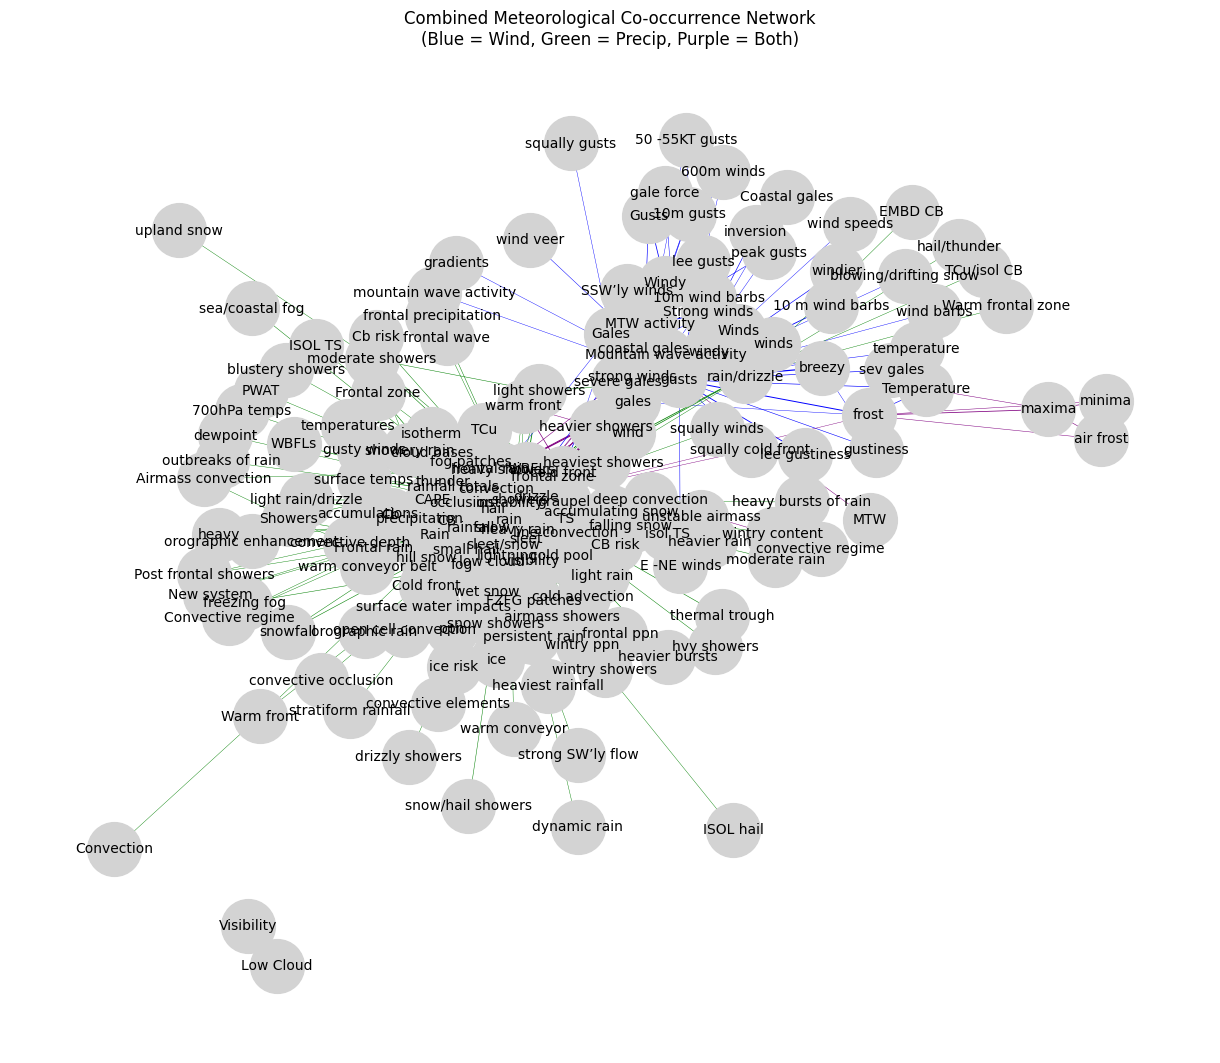

In [81]:
from collections import defaultdict
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

def compute_co_occurrence(df, column, label):
    co_occ = defaultdict(int)
    for terms in df[[column]].apply(lambda row: sum(row.dropna().tolist(), []), axis=1):
        unique_terms = set(terms)
        for term1, term2 in combinations(sorted(unique_terms), 2):
            co_occ[(term1, term2)] += 1
    return {k: (v, label) for k, v in co_occ.items()}

# Compute separately
wind_co = compute_co_occurrence(df, 'Wind', 'wind')
precip_co = compute_co_occurrence(df, 'Precipitation', 'precip')

# Merge with origin tracking
merged_co = defaultdict(lambda: {'weight': 0, 'origin': set()})

for co_dict in [wind_co, precip_co]:
    for (term1, term2), (weight, source) in co_dict.items():
        merged_co[(term1, term2)]['weight'] += weight
        merged_co[(term1, term2)]['origin'].add(source)

# Create the graph
G = nx.Graph()
for (term1, term2), attr in merged_co.items():
    if attr['weight'] > 5:
        G.add_edge(term1, term2, weight=attr['weight'], origin=attr['origin'])

# Plotting with different edge colors
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.4)

edge_colors = []
edge_styles = []
for u, v in G.edges():
    origin = G[u][v]['origin']
    if origin == {'wind'}:
        edge_colors.append('blue')
    elif origin == {'precip'}:
        edge_colors.append('green')
    else:  # shared
        edge_colors.append('purple')

weights = [G[u][v]['weight'] * 0.05 for u, v in G.edges()]

nx.draw(
    G, pos, with_labels=True, node_size=1500, font_size=10,
    width=weights, edge_color=edge_colors, node_color='lightgray'
)

plt.title("Combined Meteorological Co-occurrence Network\n(Blue = Wind, Green = Precip, Purple = Both)")
plt.show()

In [84]:
pip install plotly

   ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/16.3 MB 5.6 MB/s eta 0:00:03
   ----- ---------------------------------- 2.1/16.3 MB 7.3 MB/s eta 0:00:02
   --------- ------------------------------ 3.7/16.3 MB 7.5 MB/s eta 0:00:02
   ------------ --------------------------- 5.2/16.3 MB 7.6 MB/s eta 0:00:02
   ----------------- ---------------------- 7.1/16.3 MB 7.9 MB/s eta 0:00:02
   --------------------- ------------------ 8.7/16.3 MB 8.0 MB/s eta 0:00:01
   ------------------------- -------------- 10.5/16.3 MB 8.1 MB/s eta 0:00:01
   ------------------------------ --------- 12.3/16.3 MB 8.1 MB/s eta 0:00:01
   ---------------------------------- ----- 14.2/16.3 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------  16.0/16.3 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 16.3/16.3 MB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
pip install pyvis

   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 756.0/756.0 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [88]:
import pandas as pd
from collections import defaultdict
from itertools import combinations
import networkx as nx
from pyvis.network import Network

In [89]:
# --- Define co-occurrence function ---
def compute_co_occurrence(df, column, label):
    co_occ = defaultdict(int)
    for terms in df[[column]].apply(lambda row: sum(row.dropna().tolist(), []), axis=1):
        unique_terms = set(terms)
        for term1, term2 in combinations(sorted(unique_terms), 2):
            co_occ[(term1, term2)] += 1
    return {k: (v, label) for k, v in co_occ.items()}

# --- Compute both co-occurrence sets ---
wind_co = compute_co_occurrence(df, 'Wind', 'wind')
precip_co = compute_co_occurrence(df, 'Precipitation', 'precip')

# --- Merge co-occurrence with origin tracking ---
merged_co = defaultdict(lambda: {'weight': 0, 'origin': set()})
for co_dict in [wind_co, precip_co]:
    for (term1, term2), (weight, source) in co_dict.items():
        merged_co[(term1, term2)]['weight'] += weight
        merged_co[(term1, term2)]['origin'].add(source)

# --- Build graph ---
G = nx.Graph()
for (term1, term2), attr in merged_co.items():
    if attr['weight'] > 30:  # filter weak links
        G.add_edge(term1, term2, weight=attr['weight'], origin=attr['origin'])

# --- Visualise with PyVis ---
net = Network(height="800px", width="100%", bgcolor="#ffffff", font_color="black")
net.force_atlas_2based()

# Add nodes
for node in G.nodes():
    net.add_node(node, label=node)

# Add edges with color
for u, v in G.edges():
    origin = G[u][v]['origin']
    color = 'blue' if origin == {'wind'} else 'green' if origin == {'precip'} else 'purple'
    net.add_edge(u, v, color=color, value=G[u][v]['weight'])

# Save and open
net.save_graph("co_occurrence_network.html")
print("✅ Saved: co_occurrence_network.html — open it in your browser!")


✅ Saved: co_occurrence_network.html — open it in your browser!
